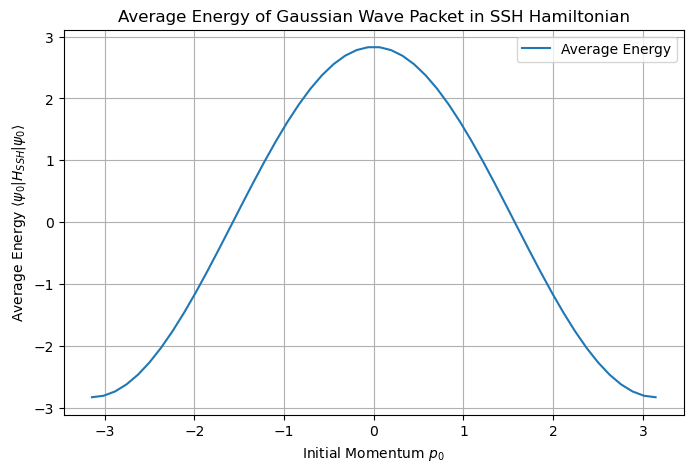

-1.570796326794903

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

# Define the SSH Hamiltonian with position-dependent hopping
def build_ssh_hamiltonian(N, v, w, sigma):
    """
    Build the NxN SSH Hamiltonian for a chain of length N
    with open boundary conditions and alternating hopping:
       - Bond (i -> i+1) has amplitude v if i is even,
         and w if i is odd (or vice versa).
    """
    SHH = np.zeros((N, N), dtype=complex)
    for i in range(N - 1):
        v_i = v * ((i + 1) / (N - 1))**sigma
        w_i = w * ((i + 1) / (N - 1))**sigma
        if i % 2 == 0:
            SHH[i + 1, i] = v_i
            SHH[i, i + 1] = v_i
        else:
            SHH[i + 1, i] = w_i
            SHH[i, i + 1] = w_i
    return SHH


def tb_model(N,sigma):
    J=1
    # Construct the tight-binding Hamiltonian matrix
    H_tb = np.zeros((N, N), dtype=complex)
    for i in range(N - 1):
      J_i = J * ((i + 1) / (N - 1))**sigma
      H_tb[i, i + 1] = -J_i
      H_tb[i + 1, i] = -J_i

    return H_tb
# Define a Gaussian wave packet
def gaussian_wave_packet(N, n0, p0, omega):
    """
    Create a normalized Gaussian wave packet in 1D:
      psi(n) = exp(-0.5*((n-n0)/omega)^2) * exp(i * p0 * n),
    with n in [0, N-1].
    """
    n = np.arange(N)
    psi = np.exp(-0.5 * ((n - n0) / omega)**2) * np.exp(1j * p0 * n)
    psi /= np.linalg.norm(psi)  # Normalize
    return psi

# Parameters
N = 1000  # Number of sites
v = 1  # Initial hopping amplitude for even bonds
w = 2  # Initial hopping amplitude for odd bonds
sigma = 1.5  # Position dependence parameter
n0 = N   # Center of the wave packet
omega = 50  # Width of the Gaussian wave packet
p0_values = np.linspace(-np.pi, np.pi, 50)  # Range of initial momenta

# Compute average energy for different p0 values
average_energies = []

for p0 in p0_values:
    H = build_ssh_hamiltonian(N, v, w, sigma)
    #H = tb_model(N,sigma)
    psi = gaussian_wave_packet(N, n0, p0, omega)
    avg_energy = np.real(np.vdot(psi, H @ psi))  # Calculate <psi|H|psi>
    average_energies.append(avg_energy)

# Plot average energy vs initial momentum
plt.figure(figsize=(8, 5))
plt.plot(p0_values, average_energies, label="Average Energy")
plt.xlabel("Initial Momentum $p_0$")
plt.ylabel("Average Energy $\\langle \\psi_0 | H_{SSH} | \\psi_0 \\rangle$")
plt.title("Average Energy of Gaussian Wave Packet in SSH Hamiltonian")
plt.legend()
plt.grid()
plt.show()

################################################################################################
from scipy.optimize import root_scalar

# Function to compute average energy for a given p0
def average_energy(p0):
    psi = gaussian_wave_packet(N, n0, p0, omega)
    H = build_ssh_hamiltonian(N, v, w, sigma)
    #H = tb_model(N,sigma)
    return np.real(np.vdot(psi, H @ psi))

# Ensure the range where the root exists has different signs
p0_left, p0_right = None, None
for i in range(len(p0_values) - 1):
    if average_energies[i] * average_energies[i + 1] < 0:  # Opposite signs
        p0_left = p0_values[i]
        p0_right = p0_values[i + 1]
        break

# Use root_scalar to find the exact p0 where average_energy is zero
if p0_left is not None and p0_right is not None:
    result = root_scalar(average_energy, bracket=[p0_left, p0_right], method='brentq')
    p0_exact = result.root if result.converged else None
else:
    p0_exact = None

p0_exact

In [5]:
from scipy.optimize import root_scalar

# Function to compute average energy for a given p0
def average_energy(p0):
    psi = gaussian_wave_packet(N, n0, p0, omega)
    H = build_ssh_hamiltonian(N, v, w, sigma)
    return np.real(np.vdot(psi, H @ psi))

# Ensure the range where the root exists has different signs
p0_left, p0_right = None, None
for i in range(len(p0_values) - 1):
    if average_energies[i] * average_energies[i + 1] < 0:  # Opposite signs
        p0_left = p0_values[i]
        p0_right = p0_values[i + 1]
        break

# Use root_scalar to find the exact p0 where average_energy is zero
if p0_left is not None and p0_right is not None:
    result = root_scalar(average_energy, bracket=[p0_left, p0_right], method='brentq')
    p0_exact = result.root if result.converged else None
else:
    p0_exact = None

p0_exact


-1.5707963267948963

Constructing SSH Hamiltonian with N=1000, t1=1.0, t2=1.5, gamma=0...
Diagonalizing the Hamiltonian...
Plotting eigenenergies...


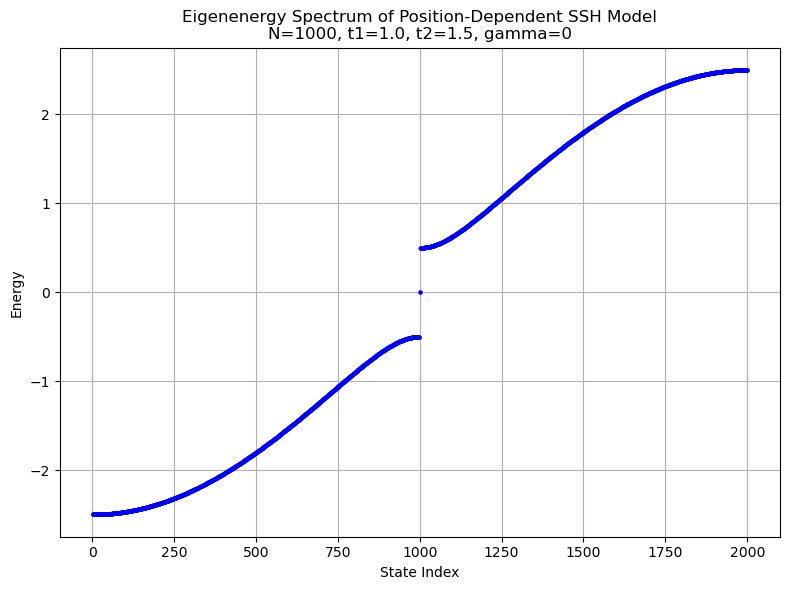

Identifying and plotting zero-energy eigenstates...
Number of zero-energy eigenstates found: 2


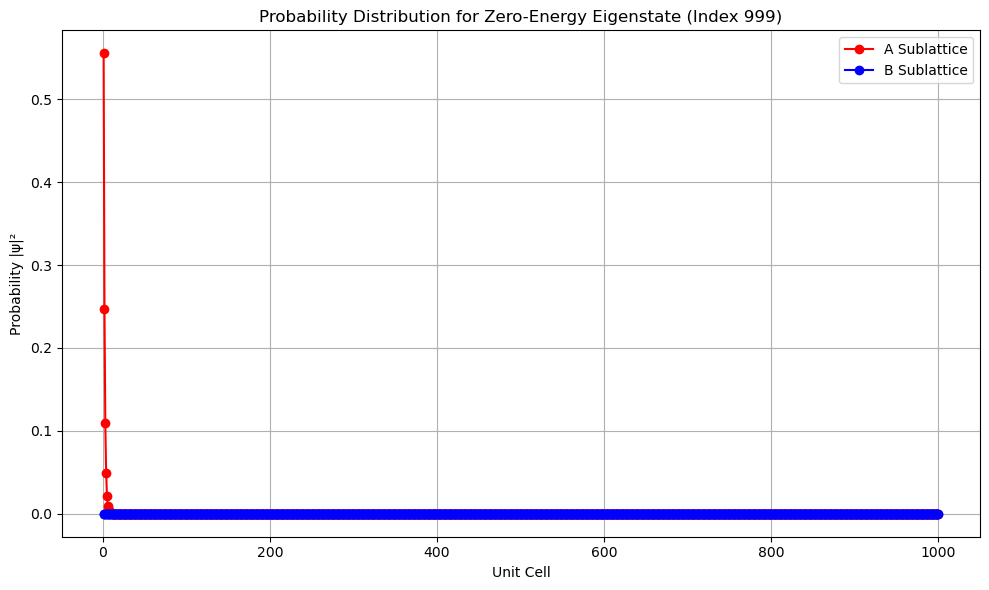

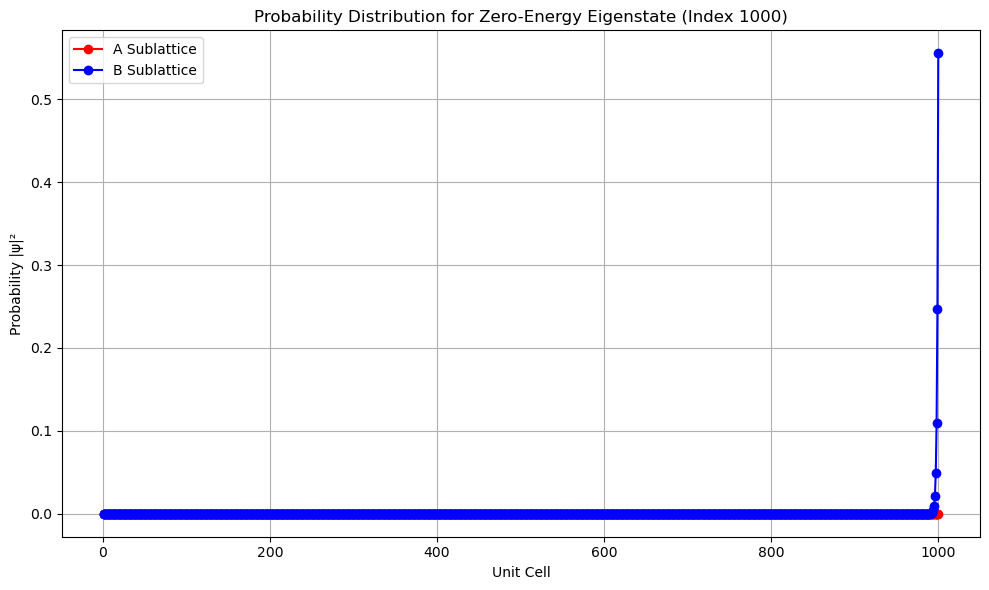

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh  # For Hermitian matrices
import warnings

def construct_ssh_hamiltonian(N, t1, t2, gamma):
    """
    Constructs the SSH Hamiltonian with position-dependent hoppings.

    Parameters:
    - N (int): Number of unit cells.
    - t1 (float): Base hopping amplitude within a unit cell.
    - t2 (float): Base hopping amplitude between unit cells.
    - gamma (float): Scaling exponent for position dependence.

    Returns:
    - H (ndarray): 2N x 2N SSH Hamiltonian matrix.
    """
    dim = 2 * N  # Two sublattices per unit cell: A and B
    H = np.zeros((dim, dim), dtype=np.float64)

    for n in range(1, N + 1):
        # Calculate position-dependent hoppings
        t1_n = t1 * (n / N) ** gamma
        t2_n = t2 * (n / N) ** gamma

        # Indices for sublattices A and B in the n-th unit cell
        A_n = 2 * (n - 1)
        B_n = 2 * (n - 1) + 1

        # On-site hoppings within the unit cell (A_n <-> B_n)
        H[A_n, B_n] = t1_n
        H[B_n, A_n] = t1_n  # Hermitian conjugate

        # Hoppings between unit cells (B_n <-> A_{n+1})
        if n < N:
            A_np1 = 2 * n  # A_{n+1}
            H[B_n, A_np1] = t2_n
            H[A_np1, B_n] = t2_n  # Hermitian conjugate

    return H

def plot_eigenenergies(eigenvalues, N, t1, t2, gamma):
    """
    Plots the eigenenergies of the SSH Hamiltonian.

    Parameters:
    - eigenvalues (ndarray): Array of eigenenergies.
    - N (int): Number of unit cells.
    - t1 (float): Base hopping amplitude within a unit cell.
    - t2 (float): Base hopping amplitude between unit cells.
    - gamma (float): Scaling exponent.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(eigenvalues) + 1), np.sort(eigenvalues), 'b.', markersize=4)
    plt.title(f'Eigenenergy Spectrum of Position-Dependent SSH Model\nN={N}, t1={t1}, t2={t2}, gamma={gamma}')
    plt.xlabel('State Index')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_zero_energy_eigenstates(eigenvalues, eigenvectors, N, threshold=1e-5):
    """
    Identifies and plots the probability distribution of zero-energy eigenstates.

    Parameters:
    - eigenvalues (ndarray): Array of eigenenergies.
    - eigenvectors (ndarray): Matrix of eigenvectors (each column is an eigenvector).
    - N (int): Number of unit cells.
    - threshold (float): Energy threshold to identify zero-energy states.
    """
    # Identify eigenstates with energies close to zero
    zero_energy_indices = np.where(np.abs(eigenvalues) < threshold)[0]

    if len(zero_energy_indices) == 0:
        print("No zero-energy eigenstates found within the specified threshold.")
        return

    print(f"Number of zero-energy eigenstates found: {len(zero_energy_indices)}")

    for idx in zero_energy_indices:
        eigenstate = eigenvectors[:, idx]
        # Probability distribution: |ψ|^2
        probability = np.abs(eigenstate)**2

        # Separate into A and B sublattices
        A_prob = probability[::2]
        B_prob = probability[1::2]

        # Positions for plotting
        positions = np.arange(1, N + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(positions, A_prob, 'ro-', label='A Sublattice')
        plt.plot(positions, B_prob, 'bo-', label='B Sublattice')
        plt.title(f'Probability Distribution for Zero-Energy Eigenstate (Index {idx})')
        plt.xlabel('Unit Cell')
        plt.ylabel('Probability |ψ|²')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def main():
    # ---------------------------
    # Parameter Initialization
    # ---------------------------
    N = 1000          # Number of unit cells
    t1 = 1.0         # Base hopping amplitude within a unit cell
    t2 = 1.5         # Base hopping amplitude between unit cells (set t2 > t1 for topological phase)
    gamma = 0     # Scaling exponent

    print(f"Constructing SSH Hamiltonian with N={N}, t1={t1}, t2={t2}, gamma={gamma}...")

    # ---------------------------
    # Hamiltonian Construction
    # ---------------------------
    H = construct_ssh_hamiltonian(N, t1, t2, gamma)

    # ---------------------------
    # Eigenvalue and Eigenvector Computation
    # ---------------------------
    print("Diagonalizing the Hamiltonian...")
    eigenvalues, eigenvectors = eigh(H)  # eigh is optimized for Hermitian matrices

    # ---------------------------
    # Eigenenergy Plotting
    # ---------------------------
    print("Plotting eigenenergies...")
    plot_eigenenergies(eigenvalues, N, t1, t2, gamma)

    # ---------------------------
    # Zero-Energy Eigenstate Identification and Plotting
    # ---------------------------
    print("Identifying and plotting zero-energy eigenstates...")
    plot_zero_energy_eigenstates(eigenvalues, eigenvectors, N, threshold=1e-5)

if __name__ == "__main__":
    # Suppress potential warnings for cleaner output
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        main()


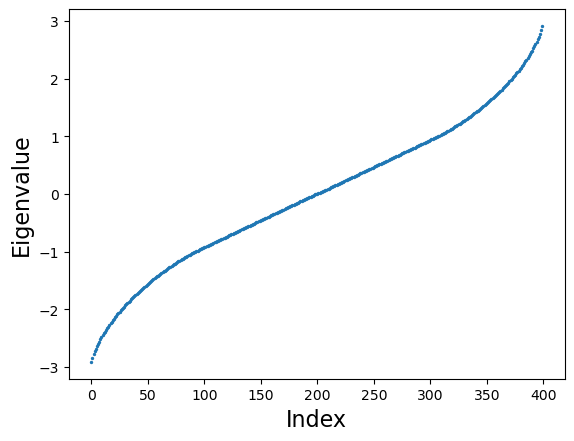

0.9318083916224487
0.7487399984545339


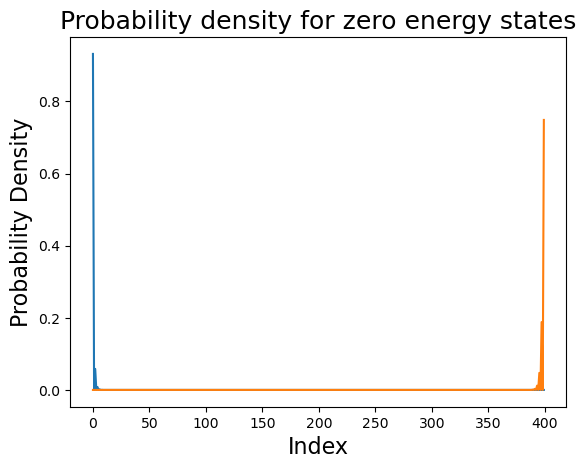

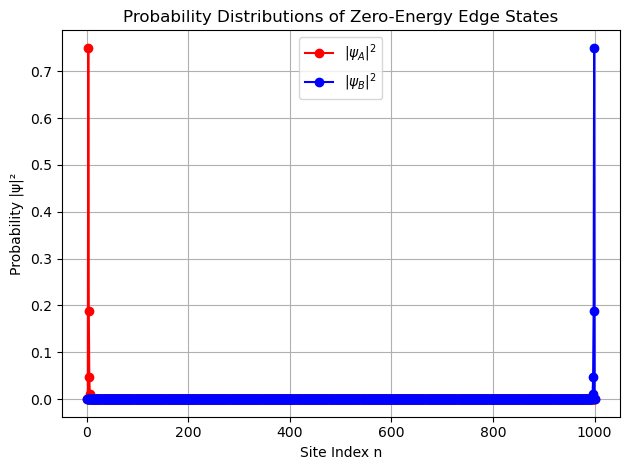

In [72]:
import numpy as np
import matplotlib.pyplot as plt

L= 400

sigma=1 #wrapping of space-time
w=2
v=1
SHH = np.zeros((L,L),dtype=complex )

for i in range (L-1):
            v_i = v * ((i + 1) /(L-1))**sigma
            w_i = w * ((i + 1) /(L-1))**sigma
            if i % 2 == 0:
              SHH[i+1,i]=v_i
              SHH[i,i+1]=v_i
            if i % 2 != 0:
             SHH[i+1,i]=w_i
             SHH[i,i+1]=w_i
#SHH[L-1,0]=w
#SHH[0,L-1]=w
#print(SHH)

eigenvalues, eigenvectors = np.linalg.eigh(SHH)
plt.scatter(np.arange(len(eigenvalues)), eigenvalues,s=2)  
#print(eigenvalues[397],eigenvalues[398],eigenvalues[399],eigenvalues[400],eigenvalues[401],eigenvalues[402], eigenvalues[403])
#print(eigenvalues[501]-eigenvalues[498])

#-----------------------------------------------------------------------------------

# # Filter the eigenvalues and corresponding x-range (indices) to plot only for x = 450 to 550
x_range = np.arange(230, 270)  # x indices from 450 to 550
filtered_eigenvalues = eigenvalues[230:270]

# Plot the filtered data
#plt.scatter(x_range, filtered_eigenvalues, s=6)
plt.xlabel('Index', fontsize= 16)
plt.ylabel('Eigenvalue',fontsize= 16)
#plt.title(f'Topologically nontrivial SSH: v={v}, w={w}, ',fontsize= 18)
plt.show()

#--------------------------------------------------------------------------------------------------

#probability_density = np.abs(eigenvectors[:, 150])**2 
probability_density = np.abs(eigenvectors[:, L//2])**2 #------------------------------------------------------
probability_density2 = np.abs(eigenvectors[:, L//2-1])**2
plt.figure() 
plt.title(f"Probability density for zero energy states", fontsize=18)
plt.plot(np.arange(len(eigenvalues)), probability_density)
plt.plot(np.arange(len(eigenvalues)), probability_density2)
plt.xlabel('Index', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
#plt.yscale('log')





######################################################################################################------------------------------------------------------------------------------------------------------------




# # Number of eigenvectors
# num_eigenvectors = len(eigenvalues)

# # Number of eigenvectors to include in each matrix (half in each case)
# num_eigenvectors_half = num_eigenvectors // 2

# # matrix from the first half of the eigenvectors
# Um= np.column_stack(eigenvectors[:, :num_eigenvectors_half])

# # matrix from the remaining half of the eigenvectors
# Up= np.column_stack(eigenvectors[:, num_eigenvectors_half:])

# trans_Um = np.transpose(Um)
# trans_Up= np.transpose(Up)

# Pp= trans_Up@Up
# Pm=trans_Um@Um
# Q=Pp-Pm
# GA=np.zeros((L,L))
# GB=np.zeros((L,L))
# for i in range(len(eigenvalues)):
#     if i % 2 == 0:
#       GA[i,i]=1
# for i in range(len(eigenvalues)):
#     if i % 2 != 0:
#       GB[i,i]=1

# Qab= GA@Q@GB
# Qba= GB@Q@GA
# l=np.arange(-abs(L/4), abs(L/4) , 1 )
# X= np.zeros((L,L))
# X[0,0]=-L/4
# for i in range(len(eigenvalues)):
#         if i % 2 == 0:
#          X[i,i]=-L/4+i/2
#          X[i+1,i+1]=X[i,i]
# #print(np.shape(GA))
# #print(X)

# v1=1/2*(Qba@(X@Qab-Qab@X))
# v2=1/2*(Qab@(Qba@X-X@Qba))
# #print(v1)
# #--------------------------------------------
# v=np.zeros(int(L/2))
# #--------------------------------------- 
# for i in range(int(L/2)-1):
#     v[i]  = v1[2*i,2*i]+v1[2*i+1,2*i+1]+v2[2*i,2*i]+v2[2*i+1,2*i+1]
# #print(v)
# plt.figure()
# plt.title("Topological marker")
# plt.xlabel("(l)--->")
# plt.ylabel("v(l)--->")
# plt.scatter(np.arange(len(v)),v,s=3)
# print(X[0,0])

###################################################################################################################################
print(max(probability_density))
print(max(probability_density2))


#######################################################################################################################################

#ANALYTICAL PLOTTING---------



# # Initialize psi_A and psi_B
# psi_B = np.zeros(N) 
# psi_A = np.zeros(N)
# r = v / w
# # Calculate psi_A and psi_B
# for n in range(N):
#     psi_A[n] = (-v / w)**(n - 1) 
#     psi_B[n] = (-v / w)**(N - n) * (N / (n + 1))**sigma

# # Normalize psi_A
# norm_A = np.sqrt(np.sum(np.abs(psi_A)**2))  # Compute norm
# psi_A_normalized = psi_A*((1-r**2)/(1-r**(2*N)))**0.5           # Normalize

# # Normalize psi_B
# norm_B = np.sqrt(np.sum(np.abs(psi_B)**2))  # Compute norm
# #psi_B_normalized = psi_B / norm_B           # Normalize


# # def compute_sum(N, sigma, v, w):
# """
#     Computes the sum S = sum_{n=1}^N (1/n^sigma) * (-t2/t1)^(N-n)
    
#     Parameters:
#     - N (int): Number of terms in the sum
#     - sigma (float): Exponent in the denominator
#     - t1 (float): Constant t1
#     - t2 (float): Constant t2
    
#     Returns:
#     - S (float): The computed sum
#     """
# r = v / w
# terms = np.array([1 / (n**sigma) * (-r)**(N - n) for n in range(1, N + 1)])
# S = np.sum(terms)
# psi_BN=(1/(S*N**sigma))**0.5
# # return psi_BN
# psi_B_normalized= psi_B*psi_BN





# # Compute probabilities for both wavefunctions
# probability_A = np.abs(psi_A_normalized)**2
# probability_B = np.abs(psi_B_normalized)**2

# # Plot normalized wavefunctions and probabilities
# plt.figure()

# # # Plot normalized wavefunctions
# # plt.subplot(1, 2, 1)
# # plt.plot(np.arange(N), probability_A, label=r"$\psi_A$")
# # plt.plot(np.arange(N), probability_B, label=r"$\psi_B$")
# # plt.title("Normalized Wavefunctions")
# # plt.xlabel("Site Index n")
# # plt.ylabel(r"$\psi(n)$")
# # plt.legend()
# # plt.grid()

# # Plot probabilities
# # plt.subplot(1, 2, 2)
# plt.plot(np.arange(N), probability_A, label=r"$|\psi_A|^2$")
# plt.plot(np.arange(N), probability_B, label=r"$|\psi_B|^2$")
# plt.title("Probability Distributions")
# plt.xlabel("Site Index n")
# plt.ylabel("Probability")
# plt.legend()
# plt.grid()

# plt.tight_layout()
# plt.show()
###########################################################################################################################################



# Initialize psi_A and psi_B with N elements each
psi_A = np.zeros(N, dtype=np.float64)
psi_B = np.zeros(N, dtype=np.float64)

# Calculate ratio r = v / w
r = v/w

# Calculate psi_A and psi_B based on analytical expressions
for n in range(1, N-1):
    # Left Edge State (psi_A): localized on A sublattice
    psi_A[n+1] = (-r)**(n)
    
    # Right Edge State (psi_B): localized on B sublattice
    # Ensure n != 0 to avoid division by zero
    psi_B[n] = (-r)**(N - n) * (N / n)**sigma

# Normalize psi_A
norm_A = np.sqrt(np.sum(np.abs(psi_A)**2))
psi_A_normalized = psi_A / norm_A

# Normalize psi_B
norm_B = np.sqrt(np.sum(np.abs(psi_B)**2))
psi_B_normalized = psi_B / norm_B

# Compute probabilities for both wavefunctions
probability_A = np.abs(psi_A_normalized)**2
probability_B = np.abs(psi_B_normalized)**2
##########################################################################


    # psi_n_unnormalized = (r)**(N - n_sites) * (N / n_sites)**sigma
    
    # # Compute the normalization factor: sqrt(sum |psi_n|^2)
    # norm_factor = np.sqrt(np.sum(np.abs(psi_n_unnormalized)**2))
    
    # # Normalize the wavefunction
    # psi_n_normalized = psi_n_unnormalized / norm_factor
    
    # # Compute the probability distribution |psi_n|^2
    # probability = np.abs(psi_n_normalized)**2
    


##########################################################################

# Plot probabilities
plt.figure()
sites = np.arange(1, N + 1)

plt.plot(sites, probability_A, 'ro-', label=r"$|\psi_A|^2$")
plt.plot(sites, probability_B, 'bo-', label=r"$|\psi_B|^2$")
plt.title("Probability Distributions of Zero-Energy Edge States")
plt.xlabel("Site Index n")
plt.ylabel("Probability |ψ|²")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



############################################################################################################################



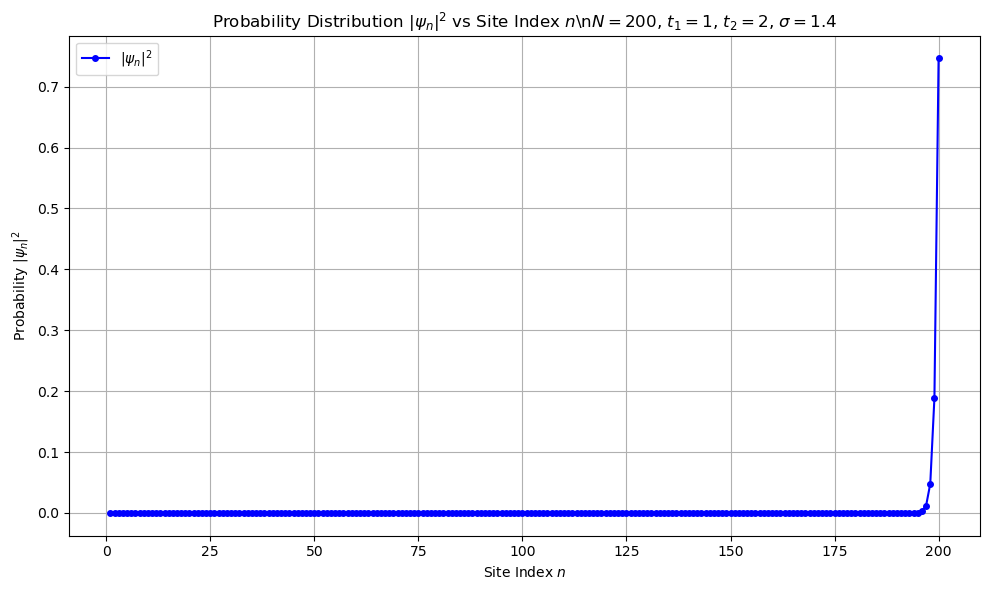

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_wavefunction(N, t1, t2, sigma):
    """
    Computes the normalized wavefunction probabilities |psi_n|^2 based on the given recurrence relation.
    
    Parameters:
    - N (int): Total number of sites (unit cells)
    - t1 (float): Hopping amplitude within a unit cell
    - t2 (float): Hopping amplitude between unit cells
    - sigma (float): Exponent in the recurrence relation
    
    Returns:
    - n_sites (ndarray): Array of site indices from 1 to N
    - probability (ndarray): Normalized probability |psi_n|^2 for each site n
    """
    # Validate inputs to prevent division by zero
    if t2 == 0:
        raise ValueError("Parameter t2 must be non-zero to avoid division by zero.")
    if N <= 0:
        raise ValueError("Number of sites N must be a positive integer.")
    if sigma < 0:
        raise ValueError("Exponent sigma must be non-negative.")
    
    # Site indices from 1 to N
    n_sites = np.arange(1, N + 1)
    
    # Compute the ratio r = -t1/t2
    r = -t1 / t2
    
    # Compute the unnormalized wavefunction psi_n
    # Avoid division by zero for n=0 by ensuring n starts from 1
    # psi_n = r^(N-n) * (N/n)^sigma
    # Use numpy's power and broadcasting for efficient computation
    psi_n_unnormalized = (r)**(N - n_sites) * (N / n_sites)**sigma
    
    # Compute the normalization factor: sqrt(sum |psi_n|^2)
    norm_factor = np.sqrt(np.sum(np.abs(psi_n_unnormalized)**2))
    
    # Normalize the wavefunction
    psi_n_normalized = psi_n_unnormalized / norm_factor
    
    # Compute the probability distribution |psi_n|^2
    probability = np.abs(psi_n_normalized)**2
    
    return n_sites, probability

def plot_probability_distribution(n_sites, probability, N, t1, t2, sigma):
    """
    Plots the probability distribution |psi_n|^2 versus site index n.
    
    Parameters:
    - n_sites (ndarray): Array of site indices
    - probability (ndarray): Probability |psi_n|^2 for each site n
    - N (int): Total number of sites
    - t1 (float): Hopping amplitude within a unit cell
    - t2 (float): Hopping amplitude between unit cells
    - sigma (float): Exponent in the recurrence relation
    """
    plt.figure(figsize=(10, 6))
    plt.plot(n_sites, probability, 'b-o', markersize=4, label=r"$|\psi_n|^2$")
    plt.title(rf"Probability Distribution $|\psi_n|^2$ vs Site Index $n$\n$N={N}$, $t_1={t1}$, $t_2={t2}$, $\sigma={sigma}$")
    plt.xlabel("Site Index $n$")
    plt.ylabel(r"Probability $|\psi_n|^2$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # ---------------------------
    # Parameter Initialization
    # ---------------------------
    N = 200          # Total number of sites (unit cells)
    t1 = 1         # Hopping amplitude within a unit cell
    t2 = 2         # Hopping amplitude between unit cells
    sigma = 0     # Exponent in the recurrence relation
    
    # ---------------------------
    # Compute the Wavefunction
    # ---------------------------
    n_sites, probability = compute_wavefunction(N, t1, t2, sigma)
    
    # ---------------------------
    # Plot the Probability Distribution
    # ---------------------------
    plot_probability_distribution(n_sites, probability, N, t1, t2, sigma)

if __name__ == "__main__":
    main()


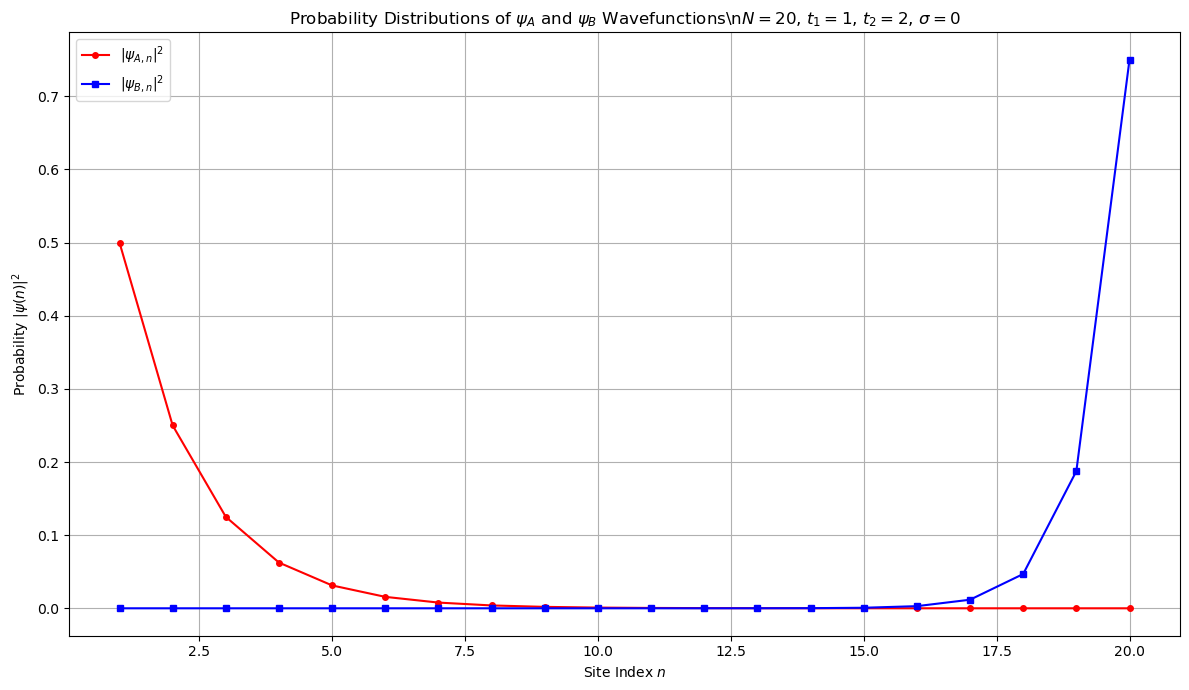

In [62]:
import numpy as np
import math
from scipy.special import gamma
import matplotlib.pyplot as plt



def compute_psi_B(N, t1, t2, sigma):
    """
    Computes and normalizes the wavefunction psi_B,n based on the given recurrence relation.
    
    Parameters:
    - N (int): Total number of sites
    - t1 (float): Hopping amplitude within a unit cell
    - t2 (float): Hopping amplitude between unit cells
    - sigma (float): Exponent in the recurrence relation
    
    Returns:
    - n_sites (ndarray): Array of site indices from 1 to N
    - probability_B (ndarray): Normalized probability |psi_B,n|^2 for each site n
    """
    n_sites = np.arange(1, N + 1)
    r = -t1 / t2
    # Compute unnormalized psi_B,n
    psi_B_unnormalized = (r)**(N - n_sites) * (N / n_sites)**sigma
    # Normalize
    norm_B = np.sqrt(np.sum(np.abs(psi_B_unnormalized)**2))
    psi_B_normalized = psi_B_unnormalized / norm_B
    # Compute probability
    probability_B = np.abs(psi_B_normalized)**2
    return n_sites, probability_B

# def compute_psi_A(N, t1, t2, sigma):
#     """
#     Computes and normalizes the wavefunction psi_A,n based on the given recurrence relation.
    
#     Parameters:
#     - N (int): Total number of sites
#     - t1 (float): Hopping amplitude within a unit cell
#     - t2 (float): Hopping amplitude between unit cells
#     - sigma (float): Not used in this recurrence relation but kept for consistency
    
#     Returns:
#     - n_sites (ndarray): Array of site indices from 1 to N
#     - probability_A (ndarray): Normalized probability |psi_A,n|^2 for each site n
#     """
#     n_sites = np.arange(1, N + 1)
#     r = -t1 / t2
#     # Compute unnormalized psi_A,n
#     psi_A_unnormalized = (r)**((n_sites - 1)/2)*(math.factorial(n_sites-1))/(2**(n_sites-1)*math.factorial((n_sites - 1)/2))
#     # Normalize
#     norm_A = np.sqrt(np.sum(np.abs(psi_A_unnormalized)**2))
#     psi_A_normalized = psi_A_unnormalized / norm_A
#     # Compute probability
#     probability_A = np.abs(psi_A_normalized)**2
#     return n_sites, probability_A


# def compute_psi_A(N, t1, t2, sigma):
#     """
#     Computes and normalizes the wavefunction psi_A,n based on the given recurrence relation.
    
#     Parameters:
#     - N (int): Total number of sites
#     - t1 (float): Hopping amplitude within a unit cell
#     - t2 (float): Hopping amplitude between unit cells
#     - sigma (float): Not used in this recurrence relation but kept for consistency
    
#     Returns:
#     - n_sites (ndarray): Array of site indices from 1 to N
#     - probability_A (ndarray): Normalized probability |psi_A,n|^2 for each site n
#     """
#     n_sites = np.arange(1, N + 1)
#     #r = -t1 / t2
#     r= complex(-t1 / t2)
#     factorial_ratio= gamma(n_sites) / (2**(n_sites - 1) * gamma((n_sites - 1)/2 + 1))
#     # Replace factorial(n-1) with gamma(n) since gamma(n)= (n-1)! for integer n.
#     # Similarly, factorial((n-1)/2) becomes gamma((n-1)/2 + 1).
#     psi_A_unnormalized = (r)**((n_sites - 1)/2) * factorial_ratio**sigma
#     #psi_A_unnormalized = (np.abs(r))**((n_sites - 1)/2) * gamma(n_sites) / (2**(n_sites - 1) * gamma((n_sites - 1)/2 + 1))

#     # psi_A_unnormalized = (r)**(n_sites - 1)
    
#     # Normalize
#     norm_A = np.sqrt(np.sum(np.abs(psi_A_unnormalized)**2))
#     psi_A_normalized = psi_A_unnormalized / norm_A
#     # Compute probability
#     probability_A = np.abs(psi_A_normalized)**2
#     return n_sites, probability_A

def compute_psi_A(N, t1, t2, sigma):
    """
    Computes and normalizes the wavefunction psi_A,n based on the given recurrence relation.
    
    Parameters:
    - N (int): Total number of sites
    - t1 (float): Hopping amplitude within a unit cell
    - t2 (float): Hopping amplitude between unit cells
    - sigma (float): Not used in this recurrence relation but kept for consistency
    
    Returns:
    - n_sites (ndarray): Array of site indices from 1 to N
    - probability_A (ndarray): Normalized probability |psi_A,n|^2 for each site n
    """
    n_sites = np.arange(1, N + 1)
    # Force r to be a NumPy complex scalar
    r = np.array(-t1/t2, dtype=complex)
    
    # Compute the ratio (using gamma functions)
    factorial_ratio = gamma(n_sites) / (2**(n_sites - 1) * gamma((n_sites - 1)/2 + 1))
    
    # Use np.power to handle array exponents in the complex domain
    term1 = np.power(r, (n_sites - 1)/2)
    term2 = factorial_ratio**sigma
    psi_A_unnormalized = term1 * term2
    
    # Normalize the wavefunction
    norm_A = np.sqrt(np.sum(np.abs(psi_A_unnormalized)**2))
    psi_A_normalized = psi_A_unnormalized / norm_A
    probability_A = np.abs(psi_A_normalized)**2
    return n_sites, probability_A


def plot_probabilities(n_sites, probability_A, probability_B, N, t1, t2, sigma):
    """
    Plots the probability distributions |psi_A,n|^2 and |psi_B,n|^2 versus site index n.
    
    Parameters:
    - n_sites (ndarray): Array of site indices
    - probability_A (ndarray): Probability |psi_A,n|^2 for each site n
    - probability_B (ndarray): Probability |psi_B,n|^2 for each site n
    - N (int): Total number of sites
    - t1 (float): Hopping amplitude within a unit cell
    - t2 (float): Hopping amplitude between unit cells
    - sigma (float): Exponent in the psi_B,n recurrence relation
    """
    plt.figure(figsize=(12, 7))
    
    plt.plot(n_sites, probability_A, 'r-o', markersize=4, label=r"$|\psi_{A,n}|^2$")
    plt.plot(n_sites, probability_B, 'b-s', markersize=4, label=r"$|\psi_{B,n}|^2$")
    
    plt.title(rf"Probability Distributions of $\psi_A$ and $\psi_B$ Wavefunctions\n$N={N}$, $t_1={t1}$, $t_2={t2}$, $\sigma={sigma}$")
    plt.xlabel("Site Index $n$")
    plt.ylabel(r"Probability $|\psi(n)|^2$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # ---------------------------
    # Parameter Initialization
    # ---------------------------
    N = 20          # Total number of sites (unit cells)
    t1 = 1         # Hopping amplitude within a unit cell
    t2 = 2        # Hopping amplitude between unit cells
    sigma = 0     # Exponent in the psi_B,n recurrence relation
    
    # ---------------------------
    # Compute Wavefunctions
    # ---------------------------
    n_sites_B, probability_B = compute_psi_B(N, t1, t2, sigma)
    n_sites_A, probability_A = compute_psi_A(N, t1, t2, sigma)
    
    # Verify that both n_sites are identical
    assert np.array_equal(n_sites_A, n_sites_B), "Site indices for psi_A and psi_B do not match."
    
    # ---------------------------
    # Plot Probability Distributions
    # ---------------------------
    plot_probabilities(n_sites_A, probability_A, probability_B, N, t1, t2, sigma)



if __name__ == "__main__":
    main()





Site indices for psi_A and psi_B match.


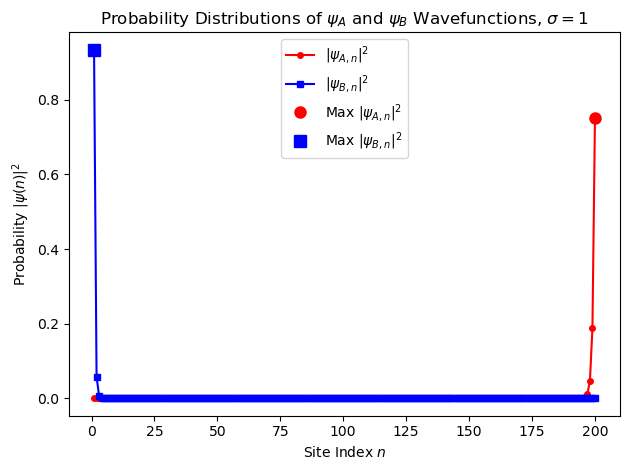

Maximum of |psi_A,n|^2: 0.750000 at site n=200
Maximum of |psi_B,n|^2: 0.934046 at site n=1


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def compute_psi_B(N, t1, t2, sigma):
    """
    Computes and normalizes the wavefunction psi_B,n based on the given recurrence relation.
    
    Parameters:
    - N (int): Total number of sites
    - t1 (float): Hopping amplitude within a unit cell
    - t2 (float): Hopping amplitude between unit cells
    - sigma (float): Exponent in the recurrence relation
    
    Returns:
    - n_sites (ndarray): Array of site indices from 1 to N
    - probability_B (ndarray): Normalized probability |psi_B,n|^2 for each site n
    """
    n_sites = np.arange(1, N + 1)
    r = -t1 / t2
    # Compute unnormalized psi_B,n
    psi_B_unnormalized = (r)**(N - n_sites) * (N / n_sites)**sigma
    # Normalize
    norm_B = np.sqrt(np.sum(np.abs(psi_B_unnormalized)**2))
    psi_B_normalized = psi_B_unnormalized / norm_B
    # Compute probability
    probability_B = np.abs(psi_B_normalized)**2
    return n_sites, probability_B

def compute_psi_A(N, t1, t2, sigma):
    """
    Computes and normalizes the wavefunction psi_A,n based on the given recurrence relation.
    
    Parameters:
    - N (int): Total number of sites
    - t1 (float): Hopping amplitude within a unit cell
    - t2 (float): Hopping amplitude between unit cells
    - sigma (float): Not used in this recurrence relation but kept for consistency
    
    Returns:
    - n_sites (ndarray): Array of site indices from 1 to N
    - probability_A (ndarray): Normalized probability |psi_A,n|^2 for each site n
    """
    n_sites = np.arange(1, N + 1)
    r = -t1 / t2
    # Compute unnormalized psi_A,n
    psi_A_unnormalized = (r)**(n_sites - 1)
    # Normalize
    norm_A = np.sqrt(np.sum(np.abs(psi_A_unnormalized)**2))
    psi_A_normalized = psi_A_unnormalized / norm_A
    # Compute probability
    probability_A = np.abs(psi_A_normalized)**2
    return n_sites, probability_A

def plot_probabilities(n_sites, probability_A, probability_B, N, t1, t2, sigma):
    """
    Plots the probability distributions |psi_A,n|^2 and |psi_B,n|^2 versus site index n.
    
    Parameters:
    - n_sites (ndarray): Array of site indices
    - probability_A (ndarray): Probability |psi_A,n|^2 for each site n
    - probability_B (ndarray): Probability |psi_B,n|^2 for each site n
    - N (int): Total number of sites
    - t1 (float): Hopping amplitude within a unit cell
    - t2 (float): Hopping amplitude between unit cells
    - sigma (float): Exponent in the psi_B,n recurrence relation
    """
    plt.figure()
    
    plt.plot(n_sites, probability_A, 'r-o', markersize=4, label=r"$|\psi_{A,n}|^2$")
    plt.plot(n_sites, probability_B, 'b-s', markersize=4, label=r"$|\psi_{B,n}|^2$")
    
    # Identifying the maximum probabilities for psi_A
    max_A = np.max(probability_A)
    max_A_index = np.argmax(probability_A) + 1  # +1 to match site index starting at 1
    plt.plot(max_A_index, max_A, 'ro', markersize=8, label=r"Max $|\psi_{A,n}|^2$")
    # plt.annotate(f"Max: {max_A:.4f} at n={max_A_index}",
    #              xy=(max_A_index, max_A),
    #              xytext=(max_A_index + N*0.05, max_A*1.1),
    #              arrowprops=dict(facecolor='red', shrink=0.05),
    #              fontsize=10,
    #              color='red')
    
    # Identifying the maximum probabilities for psi_B
    max_B = np.max(probability_B)
    max_B_index = np.argmax(probability_B) + 1  # +1 to match site index starting at 1
    plt.plot(max_B_index, max_B, 'bs', markersize=8, label=r"Max $|\psi_{B,n}|^2$")
    # plt.annotate(f"Max: {max_B:.4f} at n={max_B_index}",
    #              xy=(max_B_index, max_B),
    #              xytext=(max_B_index - N*0.05, max_B*1.1),
    #              arrowprops=dict(facecolor='blue', shrink=0.05),
    #              fontsize=10,
    #              color='blue')
    
    plt.title(rf"Probability Distributions of $\psi_A$ and $\psi_B$ Wavefunctions, $\sigma={sigma}$")
    plt.xlabel("Site Index $n$")
    plt.ylabel(r"Probability $|\psi(n)|^2$")
    plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # ---------------------------
    # Parameter Initialization
    # ---------------------------
    N = 200          # Total number of sites (unit cells)
    t1 = 2         # Hopping amplitude within a unit cell
    t2 = 1         # Hopping amplitude between unit cells
    sigma = 1      # Exponent in the recurrence relation
    
    # ---------------------------
    # Compute Wavefunctions
    # ---------------------------
    n_sites_B, probability_B = compute_psi_B(N, t1, t2, sigma)
    n_sites_A, probability_A = compute_psi_A(N, t1, t2, sigma)
    
    # Verify that both n_sites are identical
    if not np.array_equal(n_sites_A, n_sites_B):
        print("Warning: Site indices for psi_A and psi_B do not match.")
    else:
        print("Site indices for psi_A and psi_B match.")
    
    # ---------------------------
    # Plot Probability Distributions with Maxima
    # ---------------------------
    plot_probabilities(n_sites_A, probability_A, probability_B, N, t1, t2, sigma)
    
    # ---------------------------
    # Print Maximum Probabilities and Their Locations
    # ---------------------------
    # Find maximum probability for psi_A
    max_A = np.max(probability_A)
    max_A_index = np.argmax(probability_A) + 1  # +1 to match site index starting at 1
    
    # Find maximum probability for psi_B
    max_B = np.max(probability_B)
    max_B_index = np.argmax(probability_B) + 1  # +1 to match site index starting at 1
    
    # Print the results
    print(f"Maximum of |psi_A,n|^2: {max_A:.6f} at site n={max_A_index}")
    print(f"Maximum of |psi_B,n|^2: {max_B:.6f} at site n={max_B_index}")

if __name__ == "__main__":
    main()


In [47]:
import math
print(math.factorial(100)/2**200)
N=10
t1=1
t2=2
sigma=0.5
n_sites = np.arange(1, N + 1)
    # Force r to be a NumPy complex scalar
r = np.array(-t1/t2, dtype=complex)
    
    # Compute the ratio (using gamma functions)
factorial_ratio = gamma(n_sites) / (2**(n_sites - 1) * gamma((n_sites - 1)/2 + 1))
    
    # Use np.power to handle array exponents in the complex domain
term1 = np.power(r, (n_sites - 1)/2)
term2 = factorial_ratio**sigma
psi_A_unnormalized = term1 * term2
    
    # Normalize the wavefunction
norm_A = np.sqrt(np.sum(np.abs(psi_A_unnormalized)**2))
psi_A_normalized = psi_A_unnormalized / norm_A
probability_A = np.abs(psi_A_normalized)**2
print(term2)

5.807704645326249e+97
[1.         0.75112554 0.70710678 0.75112554 0.8660254  1.06225193
 1.36930639 1.83987432 2.56173769 3.67974863]


Eigenstate 1: A[0]=0.603, B[0]=-0.265   A[-1]=-0.000, B[-1]=0.054
Eigenstate 2: A[0]=-0.603, B[0]=-0.265   A[-1]=0.000, B[-1]=0.054


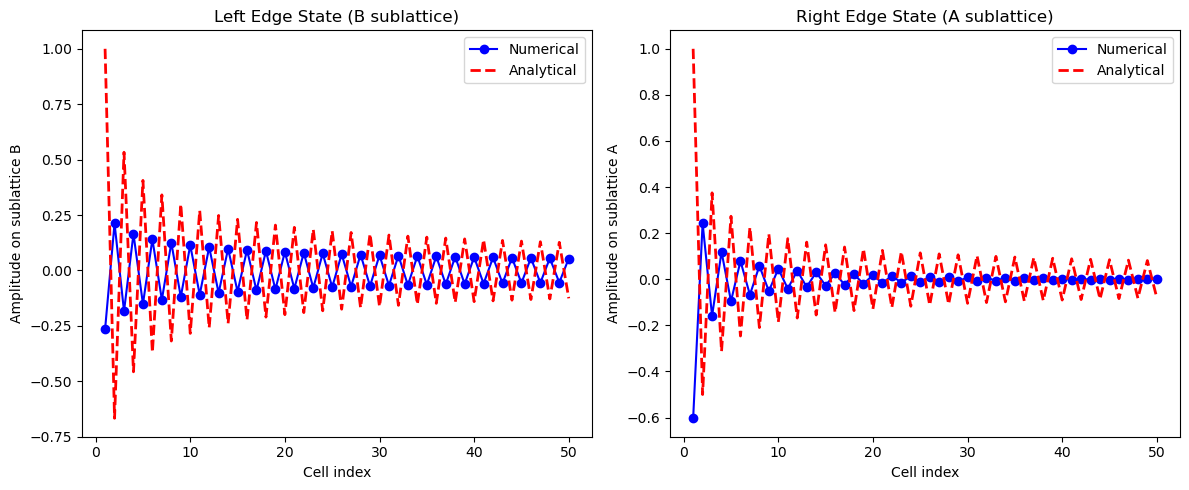

In [63]:
#ANALYTICAL VS THE NUMERICAL ZER ENERGY STATES



import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Parameters
# ------------------------------
N = 50             # number of unit cells (each with two sites)
sigma = 1.0        # exponent in the position dependence

# ------------------------------
# Define hopping amplitudes for cells:
#   For cell n = 1,...,N:
#       t1(n) = ((2n-1)/(N-1))^sigma   (intra-cell, couples A and B in the same cell)
#   For n = 1,...,N-1:
#       t2(n) = ((2n)/(N-1))^sigma       (inter-cell, couples B of cell n with A of cell n+1)
# ------------------------------
n_cells = np.arange(1, N+1)           # n = 1,...,N
t1 = ((2 * n_cells - 1) / (N - 1)) ** sigma

n_t2 = np.arange(1, N)                # for n = 1,...,N-1
t2 = ((2 * n_t2) / (N - 1)) ** sigma

# ------------------------------
# Construct the Hamiltonian matrix H (size 2N x 2N)
# We order the basis as:
#   |A,1>, |B,1>, |A,2>, |B,2>, ..., |A,N>, |B,N>
# ------------------------------
dim = 2 * N
H = np.zeros((dim, dim))

for i in range(N):
    # Map: cell i corresponds to indices (2*i, 2*i+1)
    # Intra-cell (A-B in cell i+1):
    H[2*i, 2*i+1] = t1[i]
    H[2*i+1, 2*i] = t1[i]
    
    # Inter-cell: for i = 0,...,N-2, couple B of cell i+1 with A of cell i+2:
    if i < N - 1:
        H[2*i+1, 2*(i+1)] = t2[i]
        H[2*(i+1), 2*i+1] = t2[i]

# ------------------------------
# Compute eigenvalues and eigenvectors
# ------------------------------
evals, evecs = np.linalg.eigh(H)

# Identify the two eigenstates with energies closest to zero.
abs_evals = np.abs(evals)
sorted_indices = np.argsort(abs_evals)
edge_idx1 = sorted_indices[0]
edge_idx2 = sorted_indices[1]

# Extract the two eigenvectors.
psi1 = evecs[:, edge_idx1]
psi2 = evecs[:, edge_idx2]

# It is common that one eigenstate is localized on the left edge and the other on the right.
# We now separate the amplitudes on sublattice A (even indices) and B (odd indices).
cells = np.arange(1, N+1)  # cell indices 1,...,N

A1 = psi1[0::2]   # eigenstate psi1, sublattice A
B1 = psi1[1::2]   # eigenstate psi1, sublattice B
A2 = psi2[0::2]   # eigenstate psi2, sublattice A
B2 = psi2[1::2]   # eigenstate psi2, sublattice B

# Quick check: print amplitudes at the first and last cell for both eigenstates.
print("Eigenstate 1: A[0]={:.3f}, B[0]={:.3f}   A[-1]={:.3f}, B[-1]={:.3f}".format(A1[0], B1[0], A1[-1], B1[-1]))
print("Eigenstate 2: A[0]={:.3f}, B[0]={:.3f}   A[-1]={:.3f}, B[-1]={:.3f}".format(A2[0], B2[0], A2[-1], B2[-1]))

# Based on these values, one typically finds one state with large amplitude at the left edge on the B sublattice
# (say, eigenstate 1) and one with large amplitude at the right edge on the A sublattice (say, eigenstate 2).

# ------------------------------
# Compute analytical envelopes.
# ------------------------------
# Analytical expression for the left-edge (B sublattice) state:
# beta(n) = (-1)^(n-1) * prod_{k=2}^n ((2k-2)/(2k-1))^sigma, with beta(1) = 1.
analytic_beta = np.zeros(N)
analytic_beta[0] = 1.0
for n in range(2, N+1):
    prod_val = 1.0
    for k in range(2, n+1):
        prod_val *= ((2 * k - 2) / (2 * k - 1)) ** sigma
    analytic_beta[n-1] = ((-1) ** (n-1)) * prod_val

# Analytical expression for the right-edge (A sublattice) state:
# alpha(n) = (-1)^(n-1) * prod_{k=1}^{n-1} ((2k-1)/(2k))^sigma, with alpha(1) = 1.
analytic_alpha = np.zeros(N)
analytic_alpha[0] = 1.0
for n in range(2, N+1):
    prod_val = 1.0
    for k in range(1, n):
        prod_val *= ((2 * k - 1) / (2 * k)) ** sigma
    analytic_alpha[n-1] = ((-1) ** (n-1)) * prod_val

# (For the purpose of comparison we choose the arbitrary normalizations so that the first amplitude is 1.)

# ------------------------------
# Plot the results.
# ------------------------------
plt.figure(figsize=(12,5))

# Plot for the left-edge state: numerical amplitude on the B sublattice
plt.subplot(1, 2, 1)
plt.title("Left Edge State (B sublattice)")
plt.plot(cells, B1, 'bo-', label="Numerical")
plt.plot(cells, analytic_beta, 'r--', linewidth=2, label="Analytical")
plt.xlabel("Cell index")
plt.ylabel("Amplitude on sublattice B")
plt.legend()

# Plot for the right-edge state: numerical amplitude on the A sublattice
plt.subplot(1, 2, 2)
plt.title("Right Edge State (A sublattice)")
plt.plot(cells, A2, 'bo-', label="Numerical")
plt.plot(cells, analytic_alpha, 'r--', linewidth=2, label="Analytical")
plt.xlabel("Cell index")
plt.ylabel("Amplitude on sublattice A")
plt.legend()

plt.tight_layout()
plt.show()


Eigenvalues near zero: -0.00897394003323502 0.008973940033235053


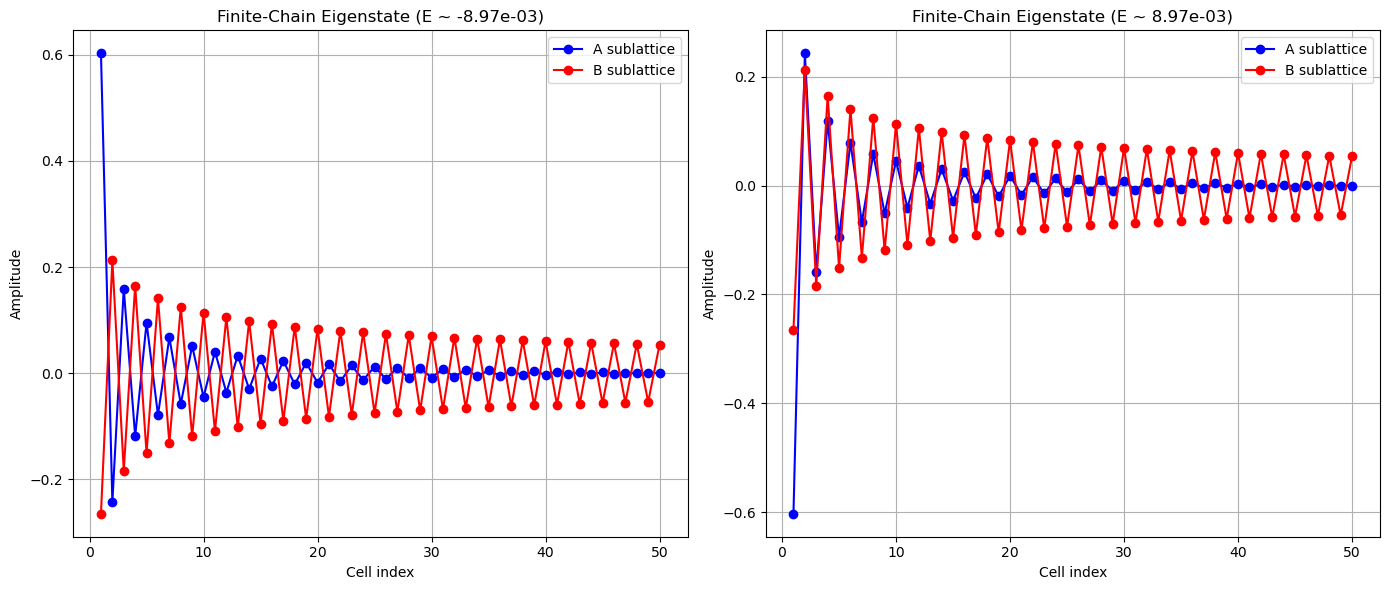

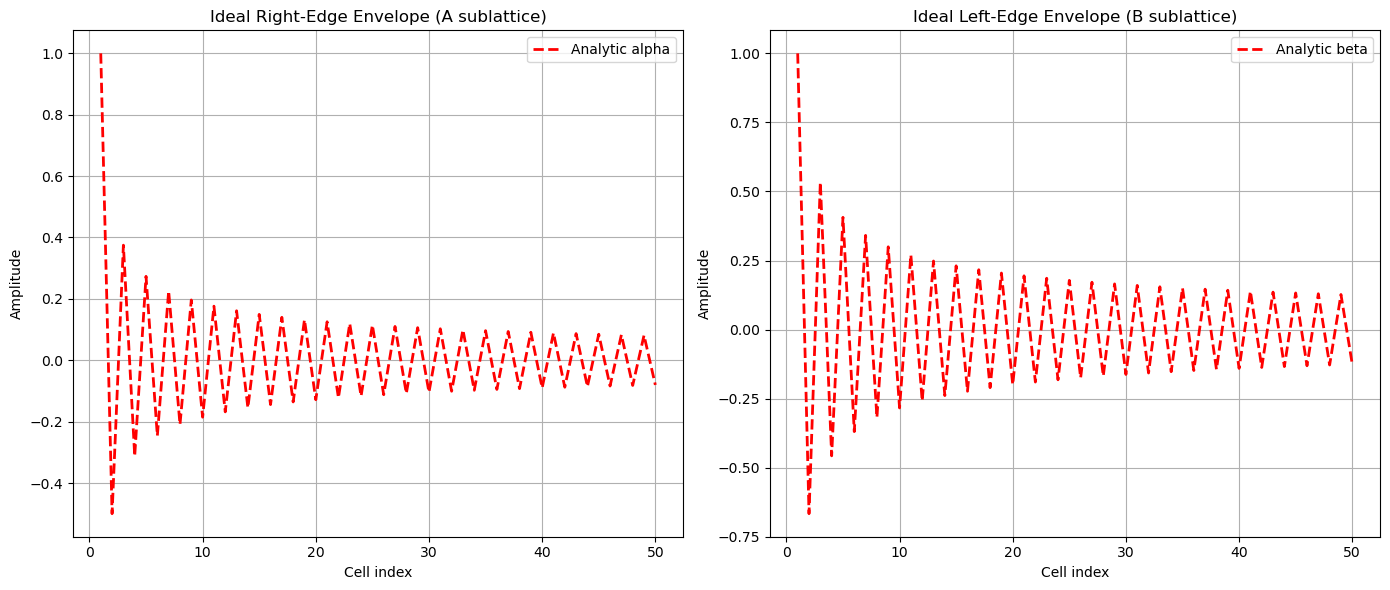

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Parameters for the finite chain
# ------------------------------
N = 50             # number of unit cells (each cell has 2 sites)
sigma = 1.0        # exponent for the position-dependent hoppings

# ------------------------------
# Define hopping amplitudes:
# For cell n = 1,...,N:
#   t1(n) = ((2n-1)/(N-1))^sigma    (intra-cell, couples A and B in same cell)
# For n = 1,...,N-1:
#   t2(n) = ((2n)/(N-1))^sigma        (inter-cell, couples B in cell n with A in cell n+1)
# ------------------------------
n_cells = np.arange(1, N+1)           # n = 1, 2, ... , N for t1
t1 = ((2 * n_cells - 1) / (N - 1)) ** sigma

n_t2 = np.arange(1, N)                # n = 1, 2, ... , N-1 for t2
t2 = ((2 * n_t2) / (N - 1)) ** sigma

# ------------------------------
# Construct the full Hamiltonian matrix H (2N x 2N)
# The basis ordering is: |A,1>, |B,1>, |A,2>, |B,2>, ..., |A,N>, |B,N>
# ------------------------------
dim = 2 * N
H = np.zeros((dim, dim))

for i in range(N):
    # Map: cell i corresponds to indices (2*i, 2*i+1)
    # Intra-cell coupling in cell i+1:
    H[2*i, 2*i+1] = t1[i]
    H[2*i+1, 2*i] = t1[i]
    
    # Inter-cell coupling: couple cell i and cell i+1 (for i = 0,...,N-2)
    if i < N - 1:
        H[2*i+1, 2*(i+1)] = t2[i]
        H[2*(i+1), 2*i+1] = t2[i]

# ------------------------------
# Diagonalize H
# ------------------------------
evals, evecs = np.linalg.eigh(H)

# Find the two eigenstates with energies closest to zero.
abs_evals = np.abs(evals)
sorted_indices = np.argsort(abs_evals)
idx1 = sorted_indices[0]
idx2 = sorted_indices[1]

psi1 = evecs[:, idx1]
psi2 = evecs[:, idx2]

print("Eigenvalues near zero:", evals[idx1], evals[idx2])

# ------------------------------
# Separate amplitudes on sublattices:
# Remember: even-index entries correspond to A sublattice, odd-index to B.
# ------------------------------
A1 = psi1[0::2]
B1 = psi1[1::2]
A2 = psi2[0::2]
B2 = psi2[1::2]

cells = np.arange(1, N+1)   # cell index

# ------------------------------
# For comparison, compute the "ideal" analytic envelopes for isolated edge states.
# (These would be exact for a semi-infinite chain.)
#
# Ideal right-edge state (localized on A sites):
analytic_alpha = np.zeros(N)
analytic_alpha[0] = 1.0
for n in range(2, N+1):
    prod_val = 1.0
    for k in range(1, n):
        prod_val *= ((2*k - 1) / (2*k)) ** sigma
    analytic_alpha[n-1] = ((-1)**(n-1)) * prod_val

# Ideal left-edge state (localized on B sites):
analytic_beta = np.zeros(N)
analytic_beta[0] = 1.0
for n in range(2, N+1):
    prod_val = 1.0
    for k in range(2, n+1):
        prod_val *= ((2*k - 2) / (2*k - 1)) ** sigma
    analytic_beta[n-1] = ((-1)**(n-1)) * prod_val

# ------------------------------
# Plot the full finite-chain numerical eigenstates.
# ------------------------------
plt.figure(figsize=(14,6))

# Plot eigenstate 1:
plt.subplot(1, 2, 1)
plt.title("Finite-Chain Eigenstate (E ~ {:.2e})".format(evals[idx1]))
plt.plot(cells, A1, 'bo-', label="A sublattice")
plt.plot(cells, B1, 'ro-', label="B sublattice")
plt.xlabel("Cell index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot eigenstate 2:
plt.subplot(1, 2, 2)
plt.title("Finite-Chain Eigenstate (E ~ {:.2e})".format(evals[idx2]))
plt.plot(cells, A2, 'bo-', label="A sublattice")
plt.plot(cells, B2, 'ro-', label="B sublattice")
plt.xlabel("Cell index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ------------------------------
# For comparison, plot the ideal envelopes.
# ------------------------------
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title("Ideal Right-Edge Envelope (A sublattice)")
plt.plot(cells, analytic_alpha, 'r--', linewidth=2, label="Analytic alpha")
plt.xlabel("Cell index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.title("Ideal Left-Edge Envelope (B sublattice)")
plt.plot(cells, analytic_beta, 'r--', linewidth=2, label="Analytic beta")
plt.xlabel("Cell index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
